### EXAMEN - Convocatoria 1 - Desarrollo
Utilizar el conjunto de datos "dataset_exam.npy" para resolver el ejercicio. Tener en cuenta que la última columna corresponde a la clase.

In [51]:
import numpy as np

from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold


#### 1) Partición de datos externa (1.5 puntos)
Realizar una partición externa de tipo hold-out seleccionando un 20% de los datos para test (fijar una semilla en 42).
Comprobar si los datos, tanto de train como de test, están balanceados.

In [25]:
data = np.load ('dataset_exam.npy') # Cargar archivo
print(np.shape(data.data))

#separamos en atributos y clase
X = data[:,:-1]
y = data[:,-1]

X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_training))

# comprobar si estan balanceados
lab_train, ocur_train = np.unique(y_training, return_counts=True)
lab_test, ocur_test = np.unique( y_testing, return_counts=True)
print('Train\n0: ', ocur_train[0], '\n1: ', ocur_train[1])
print('Test\n0: ', ocur_test[0], '\n1: ', ocur_test[1])

(492, 9)
(393, 8)
Train
0:  195 
1:  198
Test
0:  51 
1:  48


In [ ]:
# Los datos estan balanceados

#### 2) Estandarización de los datos de train y test (1.5 puntos)
Utilizar el método StandardScaler().

In [39]:
from sklearn import preprocessing

# Limpieza de datos: estandarización.
standardizer = preprocessing.StandardScaler()

X_train_std = standardizer.fit(X_training)

X_train_std = standardizer.transform(X_training)
X_test_std = standardizer.transform(X_testing)

#### 3) Selección de atributos en train y test (1.5 puntos)
Aplicar el método de información mutua para clasificación en el percentile 90.

In [49]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

# creo el selectPercentile con el metodo mutual info regression
mutual = SelectPercentile(score_func=mutual_info_regression, percentile=90)

# lo entreno
X_train_new = mutual.fit(X_train_std, y_training)

# lo aplico a los datos
X_train_new = mutual.transform(X_train_std)
X_test_new = mutual.transform(X_test_std)

# print(X_train_new)
# print(X_test_new)
print(np.shape(X_train_new))
print(np.shape(X_test_new))

(393, 7)
(99, 7)



#### 4) Comparación de modelos de clasifición mediante validación cruzada (2.5 puntos)
Aplicar una validación cruzada interna de K=5 bolsas para optimizar y comparar la capacidad predictiva de los siguientes modelos: Regresión Logística y Support Vector Machine. La comparación debe realizarse únicamente en términos de exactitud proporcionando resultados de media +- desviación estándar.

In [58]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, svm

# LOGR
# creamos el modelo
algoritmos = {'LOGR': LogisticRegression(penalty='l2', solver='saga', max_iter=1000, random_state=42, multi_class='ovr'), 
              'SVM': svm.SVC(C=10, random_state=42, probability=True),}

# validacion cruzada
y_pred = {}
for nombre, alg in algoritmos.items():
    results = cross_val_score(alg, X_train_new, y_training, cv = KFold(n_splits=5, shuffle=True, random_state=42))
    print(nombre)
    print("Accuracy:   %0.4f +/- %0.4f" % (results.mean(), results.std()))
    print()

LOGR
Accuracy:   0.6766 +/- 0.0538

SVM
Accuracy:   0.7912 +/- 0.0249



#### 5) Evaluación de los modelos sobre el conjunto de test (3 puntos)
- Entrenar los modelos anteriores utilizando todos los datos de entrenamiento.
- Evaluar su rendimiento sobre el conjunto de test.
- Mostrar en una única figura la comparación de las curvas ROC obtenidas para cada modelo.
- Crear una tabla donde se muestren los resultados de todos los modelos.
 * Las filas serán: Precisión, Sensibilidad, F-score, Exactitud y AUC
 * Las columnas serán: LR y SVM
- Mostrar la matriz de confusión proporcionada por el mejor modelo. 

In [65]:
import sklearn.metrics as metrics

# Métricas de evaluación.
metricas = {
  'ACC':    metrics.accuracy_score,
  'PREC':   lambda y_true, y_pred:
            metrics.precision_score(y_true, y_pred,
              average='micro'),
  'RECALL': lambda y_true, y_pred:
            metrics.recall_score(y_true, y_pred,
              average='micro'),
  'F1':     lambda y_true, y_pred:
            metrics.f1_score(y_true, y_pred, average='micro')}

In [ ]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# entrenamos el modelo definitivo
models = {}
for nombre, alg in algoritmos.items():
    models[nombre] = alg.fit(X_train_new, y_training)

# obtenemos las predicciones
y_pred = {}
for nombre, alg in models.items():
    y_pred[nombre] = alg.predict(X_test_new)
    
print(y_pred)


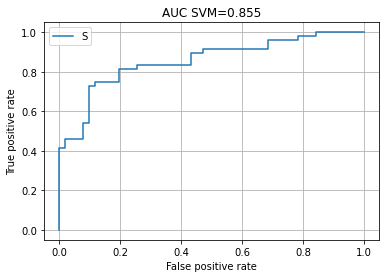

             LOGR     SVM
---------  ------  ------
Precision  0.6523  0.8
Recall     0.6489  0.7966
F1-score   0.6452  0.797
Accuracy   0.6465  0.798


In [91]:
# auc
for nombre, alg in models.items():
    y_proba_test = alg.predict_proba(X_test_new) # "predict_proba" para extraer probabilidades vez de predicciones
    auc = metrics.roc_auc_score(y_testing, y_proba_test[:, 1]) # Area Under the ROC curve (AUC)
    fpr, tpr, th = metrics.roc_curve(y_testing, y_proba_test[:,1])
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('AUC ' + nombre + '=' + str(np.round(auc,4)) )
    plt.legend(nombre)
    plt.grid()
    plt.show()
    
# Tabla de resultados
headers = ['','LOGR', 'SVM']
P,S,FS,ACC = ['Precision'], ['Recall'], ['F1-score'], ['Accuracy']

for nombre, alg in models.items():
    P.append(np.round(metrics.precision_score(y_testing, y_pred[nombre], average='macro'),4))
    S.append(np.round(metrics.recall_score(y_testing, y_pred[nombre], average='macro'),4))
    FS.append(np.round(metrics.f1_score(y_testing, y_pred[nombre], average='macro'),4))
    ACC.append(np.round(metrics.accuracy_score(y_testing, y_pred[nombre]),4))

my_data = [tuple(P), tuple(S), tuple(FS), tuple(ACC)]
print(tabulate(my_data, headers=headers))


In [92]:
# Imprimimos la matriz de confusion del mejor metodo, en este caso el SVM

print('\nMatriz de confusion:')
# Evaluación del modelo sobre el conjunto de test
for nombre, alg in models.items():
    if nombre == 'SVM':
        print(nombre)
        print(metrics.confusion_matrix(y_testing, y_pred[nombre]))
        print()


Matriz de confusion:
SVM
[[43  8]
 [12 36]]

